- creer le predicteur pour chacun des timeframes (30mn - 1H - 4H - 1D/ repertoires stephane_fresh
- utiliser le modele pour predire un max de perte qui soit 2 fois inferieur au profit.
- A chaque fin de chandelle (4h ou 1h) , faire une prediction pour :
- si la chandelle qui se termine est negative (cad close<open) :
  - probabilite que le LOW de la prochaine chandelle soit au moins 20 points plus bas que le CLOSE de la chandelle qui s'est terminee.
  - probabilite que le HIGH del la prochaine chandelle soit maximum 18 pips au dessus du CLOSE
- si la chandelle qui se termine est positive (cad open<close) :
  - probabilite que le HIGH de la prochaine chandelle soit au moins 20 points plus haut que le CLOSE de la chandelle qui s'est terminee.
  - probabilite que le LOW soit max 18 pips en dessous du CLOSE


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import xgboost as xgb
from datetime import datetime, timedelta
from service import files_service
from model.models import TradeModel

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Set folder for data

In [2]:
PATH = "data/test_all_periods/"

#### Read data and convert to TradeModel

In [4]:
files = files_service.get_files(PATH,extension='.csv')
print files
files = [files[1]]

['EURUSD_UTC_1H_Bid_2010.01.01_2017.02.18.csv', 'EURUSD_UTC_30M_Bid_2010.01.01_2017.02.18.csv', 'EURUSD_UTC_4H_Bid_2010.01.01_2017.02.18.csv', 'EURUSD_UTC_1D_Bid_2017.01.01_2017.02.20.csv']


In [5]:
TradeModel_dict={}
for f in files:
    name = f.split('.csv')[0]
    frequency =  '\"' + f.split('_')[2] + '\"'
    print name, frequency
    path = PATH+f
    tm = TradeModel(path,name,frequency=frequency)
    TradeModel_dict[name]= tm

EURUSD_UTC_30M_Bid_2010.01.01_2017.02.18 "30M"


In [6]:
tm =TradeModel_dict['EURUSD_UTC_30M_Bid_2010.01.01_2017.02.18']

In [27]:
%qtconsole

In [7]:
tm.df.head()

,Open,High,Low,Close,Volume,KC_M_1,KC_U_1,KC_D_1,KC_M_2,KC_U_2,...,DOWN_next_Low_under_Close,DOWN_next_High_over_Close,UP_next_High_over_Close,UP_next_Low_under_Close,DOWN_next_Low_and_High,UP_next_Low_and_High,hour,day,month,year
date_time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 11:30:00,1.43324,1.43334,1.43267,1.43306,1633.8,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,11,4,1,2010
2010-01-01 12:00:00,1.43321,1.43344,1.43258,1.43295,1542.4,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,12,4,1,2010
2010-01-01 12:30:00,1.43324,1.43336,1.43267,1.43293,2021.0,1.433000,1.433740,1.432260,1.433000,1.433740,...,0,0,0,0,0,0,12,4,1,2010
2010-01-01 13:00:00,1.43284,1.43334,1.43207,1.43276,1567.1,1.432900,1.433840,1.431960,1.432900,1.433840,...,0,0,0,0,0,0,13,4,1,2010
2010-01-01 13:30:00,1.43316,1.43352,1.43287,1.43331,1953.1,1.432981,1.433851,1.432111,1.432981,1.433851,...,0,0,0,0,0,0,13,4,1,2010


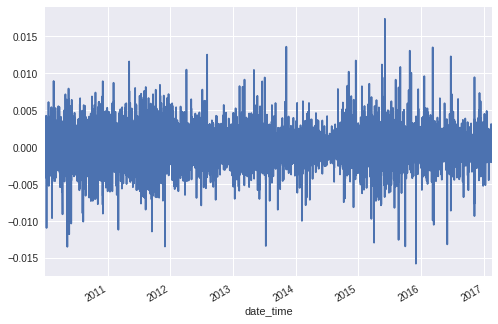

In [8]:
ax = tm.df.cs_body_size.plot()

In [13]:
#tm.plot()

#### Save TradeModel  to .csv

In [9]:
tm.df.to_csv('tradeModel_data.csv')

## Compute models and predictions

In [15]:
def train_test_split(df, date, target):
              
    predictors =tm.get_predictors_columns()
    #predictors =['Open','High','Low','High','KC_M_3','KC_U_3','ATR','EMA12','EMA30']

    df_train = df[df.index<date]
    df_test = df[df.index>=date]
    
    tm.X_train,tm.y_train = df_train[predictors].values,df_train[target].values
    tm.X_test, tm.y_test  = df_test[predictors].values,df_test[target].values  
    

In [16]:
def cv_optimize(clf,  tm,parameters={}, n_folds=5):
    
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=-1)
    gs.fit(tm.X_train, tm.y_train)
    
    return gs.best_estimator_    

In [17]:
def predict_next(tm,target,clf, parameters={}):
    
    best_clf = cv_optimize(clf,tm, parameters)
   
    prediction =  best_clf.predict_proba(tm.X_test)
    
    return prediction,best_clf

In [18]:
def compute_prediction(trade_model,target,last_index,single=True,\
                       clf=xgb.XGBClassifier(max_depth=12,n_estimators=300),\
                      params={}):

    prediction_list = []

    df = tm.df.copy()
    df = df.dropna()
    
    
    if not single:
        for dt in df.tail(last_index).index:
            print dt

            train_test_split(df,dt,target)
            predictions = predict_next(tm,target,clf,params)
            prediction_list.append((dt,tm.y_test[0],predictions[0][0],predictions[0][1]))
    else :
              
  
        dt_range =  df.iloc[-last_index:].index
        dt = dt_range[0]

        train_test_split(df,dt,target)
        predictions,clf = predict_next(tm,target,clf)

        prediction_list = zip(dt_range,tm.y_test,predictions[:,0],predictions[:,1]) 
    
    result ={}
        
    result['df'] =  pd.DataFrame(prediction_list,columns=['date','observed',target+'_FALSE', target+'_TRUE'])
    result['clf'] = clf
    result['tm'] = tm
    

    pickle.dump(result, open('data/'+trade_model.name+'_'+target+'.p', "wb"))
    
    return result

In [19]:
TARGETS = [col for col in tm.df.columns if '_next' in col]
TARGETS

['DOWN_next_Low_under_Close',
 'DOWN_next_High_over_Close',
 'UP_next_High_over_Close',
 'UP_next_Low_under_Close',
 'DOWN_next_Low_and_High',
 'UP_next_Low_and_High']

In [20]:
summary = tm.df[TARGETS].apply(pd.Series.value_counts).T
summary['ratio_TRUE']=summary[1]/summary.sum(axis=1)*100.0
summary

,0,1,ratio_TRUE
DOWN_next_Low_under_Close,7366,4170,36.147712
DOWN_next_High_over_Close,11508,28,0.242718
UP_next_High_over_Close,7364,4172,36.165049
UP_next_Low_under_Close,6909,4627,40.109223
DOWN_next_Low_and_High,11508,28,0.242718
UP_next_Low_and_High,10313,1223,10.601595


In [21]:
def compute_all_predictions(trade_model,last_index=1000,clf=None,params=None):
    for target in TARGETS:
        predictions = compute_prediction(tm,target,last_index,clf=clf,params=None,single=True)
        #!!!!!!!!!!!!!!!!!!!!!!!!!!
        #break
        #!!!!!!!!!!!!!!!!!!!!!!

### Compute all predictions

In [22]:
compute_all_predictions(tm,clf=xgb.XGBClassifier(),params= {})

KeyboardInterrupt: 

In [23]:
def load_predictions(tm_name):
    predictions_dict={}
    files = files_service.get_files('data/',extension='.p',filter_on=tm_name)
    for f in files:
        prediction_result = pickle.load(open('data/'+f, "rb"))
        predictions_dict[f.split(tm_name)[1][1:-2]]=prediction_result
        
    return predictions_dict

# Results analysis

In [24]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=10, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.6, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.6, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax

In [25]:
def analysis_result():
    
    
    ### Load data
    dico_pred = load_predictions('EURUSD_UTC_4H_Bid_2010.01.01_2017.02.18')

    
    for key in [k for k in dico_pred.keys() if 'and' in k]:
        print '--------------------'+key+'------------------'
        df_test =dico_pred[key]['df']
        
        df_test['predicted'] =( df_test[key+'_TRUE']>0.17)*1
        
        ## print Confusion Matrix
        
        print confusion_matrix(df_test.observed.values,df_test.predicted.values)

        df_test['result_OK']= np.where(df_test.predicted==df_test.observed,1,0)
        df_test =df_test.sort_values(by=key+'_TRUE')

        ### Compute Baseline
        df_test[df_test.observed==1]

        
        print 'accuracy baseline : {}%'.format(df_test.observed.value_counts()[0]*100.0/df_test.observed.count())

        ####  Accuracy and Precision
 

        accuracy = sum(df_test.result_OK)*100.0 /df_test.observed.count()
        print 'Accuracy model : {} %'.format(accuracy)
        #precision = TP/(FP+TP)
        precision = np.sum((df_test.predicted==1) & (df_test.result_OK==1)) *100.0 /np.sum(df_test.predicted==1)


        print 'Precision model : {} %'.format(precision)
        
        print dico_pred[key]['clf']
        
        make_roc(key,dico_pred[key]['clf'], dico_pred[key]['tm'].y_test,dico_pred[key]['tm'].X_test)

    

--------------------DOWN_next_Low_and_High------------------
[[998   0]
 [  2   0]]
accuracy baseline : 99.8%
Accuracy model : 99.8 %
Precision model : nan %
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
--------------------UP_next_Low_and_High------------------
[[897  51]
 [ 36  16]]
accuracy baseline : 94.8%
Accuracy model : 91.3 %
Precision model : 23.8805970149 %
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


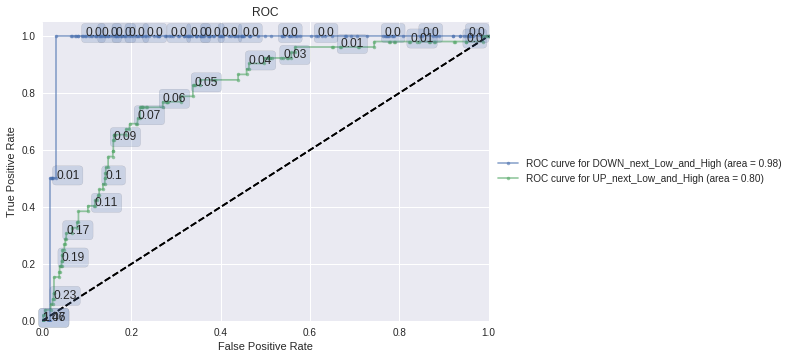

In [26]:
analysis_result()